In [79]:
import pickle
X_acl,X_ppg,y,y_participant = pickle.load(open('../data/tabular_data.p','rb'))

In [80]:
from sklearn.preprocessing import RobustScaler,MinMaxScaler

for k in range(X_ppg.shape[0]):
    X_ppg[k] = MinMaxScaler().fit_transform(X_ppg[k])

import numpy as np
X_ppg = X_ppg[:,np.arange(0,512,2),:]

X_acl = np.concatenate([X_ppg,X_acl],axis=-1)[:,:,:]

y = X_ppg[:,:,0].reshape(-1,256,1)

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,LeaveOneGroupOut,LeavePGroupsOut
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K 
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
%matplotlib notebook
from keras.layers import Conv1D,Attention,Reshape,BatchNormalization,TimeDistributed, \
Dropout,Input,MaxPooling1D,Flatten,Dense,Input, GaussianNoise,LSTM, Bidirectional, Input
from keras.models import Model, Sequential

In [82]:
logo = LeaveOneGroupOut()
logo = LeavePGroupsOut(n_groups=5)
for train_index, test_index in logo.split(X_acl, y, y_participant.reshape(-1)):
    train_x, test_x = X_acl[train_index], X_acl[test_index]
    train_y, test_y = y[train_index], y[test_index]
    train_participant, test_participant = y_participant[train_index], y_participant[test_index]
    break
train_x.shape,train_y.shape

((29067, 256, 4), (29067, 256, 1))

In [83]:
train_x, val_x, train_y, val_y = train_test_split(train_x,train_y,test_size = 0.2,random_state=42)

(train_x.shape, train_y.shape), (val_x.shape, val_y.shape),(test_x.shape,test_y.shape)

(((23253, 256, 4), (23253, 256, 1)),
 ((5814, 256, 4), (5814, 256, 1)),
 ((14296, 256, 4), (14296, 256, 1)))

In [91]:
from keras_self_attention import SeqSelfAttention
from keras import backend as K
from keras.layers import Concatenate, Flatten,LeakyReLU, Activation, RepeatVector, Permute, Multiply, Lambda, Dense, merge# Define a regular layer instead of writing a custom layer
# This layer should have just one neuron - like before
# The weights and bias shapes are automatically calculated 
# by the Framework, based on the input
# This layer is defined at step 3.5 directly

def custom_loss(y_true,y_pred):
    y_pred_attention = 1+y_pred[:,:,1]
    y_pred = y_pred[:,:,0]
    y_true = y_true[:,:,0]
    loss = K.mean(K.abs(y_true-y_pred)*y_pred_attention)
    return loss


def get_model(input_shape=(256,4),act='relu',loss="mae",opt='rmsprop',n_classes=1):
#     model =  Sequential()
#     model.add(GaussianNoise(1))
#     model.add(Conv1D(100,20,activation='linear',kernel_initializer='normal',padding='same'))
#     model.add(Conv1D(10,10,activation='relu',kernel_initializer='normal',padding='same'))
#     model.add(LeakyReLU(alpha=0.1))
    
    model2 =  Sequential()
    model2.add(Conv1D(100,20,activation=act,kernel_initializer='normal',padding='same'))
#     model.add(LeakyReLU(alpha=0.1))
    model2.add(MaxPooling1D(5))
    model2.add(BatchNormalization())
    model2.add(Dropout(.2))
    model2.add(Conv1D(100,20,activation=act,kernel_initializer='normal',padding='same'))
#     model.add(LeakyReLU(alpha=0.1))
    model2.add(MaxPooling1D(5))
    model2.add(BatchNormalization())
    model2.add(Dropout(.2))
    model2.add(Conv1D(50,10,activation=act,kernel_initializer='normal',padding='same'))
#     model.add(LeakyReLU(alpha=0.1))
    model2.add(MaxPooling1D(2))
    model2.add(BatchNormalization())
    model2.add(Flatten())
    model2.add(Dense(10,activation='relu'))
    model2.add(Reshape((5,2)))
    model2.add(Conv1D(100,2,input_shape=input_shape,activation=act,kernel_initializer='normal',padding='same'))
#     model.add(LeakyReLU(alpha=0.1))
    model2.add(BatchNormalization())
    model2.add(Dropout(.2))
    model2.add(Conv1D(256,2,input_shape=input_shape,activation='relu',kernel_initializer='normal',padding='same'))
    model2.add(Permute([2,1]))
#     model2.add(TimeDistributed(Dense(1,activation='relu')))
    
#     model2.add(Flatten())
#     model2.add(Dense(20,activation='relu'))
#     model2.add(Dense(128,activation='relu'))
#     model2.add(Dense(256,activation='relu'))
#     model2.add(Reshape((256,1)))
    model2.add(Conv1D(100,20,activation='relu',kernel_initializer='normal',padding='same'))
    model2.add(TimeDistributed(Dense(1,activation='sigmoid')))
    
    x = Input(shape=input_shape)
    x_encoded = Conv1D(10,10,activation='tanh',kernel_initializer='normal',padding='same')(x)
    e=Dense(1, activation='tanh')(x_encoded)# Now do all the softmax business taking the above o/p
    e=Flatten()(e)
    a=Activation('softmax')(e)
    temp=RepeatVector(10)(a)
    temp=Permute([2, 1])(temp)# multiply weight with lstm layer o/p
    output = merge.Multiply()([x_encoded, temp])
    output = model2(output)
    a1 = RepeatVector(1)(a)
    a1 = Permute([2, 1])(a1)
    a1 = Concatenate()([output,a1])
    model1 = Model(inputs=x,outputs=a1)
    model1.compile(loss=custom_loss,optimizer=opt)
    return model1

    
    
#     model.add(Bidirectional(LSTM(100,return_sequences=True,activation='tanh',kernel_initializer='normal')))
#     model.add(TimeDistributed(Dense(1,activation='')))
    

In [92]:
model = get_model()
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           [(None, 256, 4)]     0                                            
__________________________________________________________________________________________________
conv1d_138 (Conv1D)             (None, 256, 10)      410         input_22[0][0]                   
__________________________________________________________________________________________________
dense_66 (Dense)                (None, 256, 1)       11          conv1d_138[0][0]                 
__________________________________________________________________________________________________
flatten_44 (Flatten)            (None, 256)          0           dense_66[0][0]                   
___________________________________________________________________________________________

In [93]:
from keras.models import load_model
filepath = '../model_files/convolutional_autoencoder_no_loss_function.hdf5'
# model = load_model(filepath)

In [94]:
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20)
callbacks_list = [es,checkpoint]
history = model.fit(train_x,train_y,validation_data=(val_x,val_y), epochs=200, batch_size=500,
          callbacks=callbacks_list,shuffle=True)

Epoch 1/200
47/47 [==============================] - ETA: 0s - loss: 0.1598
Epoch 00001: val_loss improved from inf to 0.18208, saving model to ../model_files/convolutional_autoencoder_no_loss_function.hdf5
47/47 [==============================] - 1s 28ms/step - loss: 0.1598 - val_loss: 0.1821
Epoch 2/200
46/47 [============================>.] - ETA: 0s - loss: 0.1522
Epoch 00002: val_loss improved from 0.18208 to 0.18163, saving model to ../model_files/convolutional_autoencoder_no_loss_function.hdf5
47/47 [==============================] - 1s 24ms/step - loss: 0.1521 - val_loss: 0.1816
Epoch 3/200
46/47 [============================>.] - ETA: 0s - loss: 0.1475
Epoch 00003: val_loss improved from 0.18163 to 0.18116, saving model to ../model_files/convolutional_autoencoder_no_loss_function.hdf5
47/47 [==============================] - 1s 24ms/step - loss: 0.1474 - val_loss: 0.1812
Epoch 4/200
46/47 [============================>.] - ETA: 0s - loss: 0.1329
Epoch 00004: val_loss did not i

Epoch 33/200
46/47 [============================>.] - ETA: 0s - loss: 0.0975
Epoch 00033: val_loss did not improve from 0.09509
47/47 [==============================] - 1s 24ms/step - loss: 0.0975 - val_loss: 0.0953
Epoch 34/200
46/47 [============================>.] - ETA: 0s - loss: 0.0971
Epoch 00034: val_loss did not improve from 0.09509
47/47 [==============================] - 1s 24ms/step - loss: 0.0972 - val_loss: 0.1051
Epoch 35/200
46/47 [============================>.] - ETA: 0s - loss: 0.0973
Epoch 00035: val_loss did not improve from 0.09509
47/47 [==============================] - 1s 24ms/step - loss: 0.0973 - val_loss: 0.0973
Epoch 36/200
46/47 [============================>.] - ETA: 0s - loss: 0.0968
Epoch 00036: val_loss did not improve from 0.09509
47/47 [==============================] - 1s 24ms/step - loss: 0.0968 - val_loss: 0.0967
Epoch 37/200
46/47 [============================>.] - ETA: 0s - loss: 0.0966
Epoch 00037: val_loss did not improve from 0.09509
47/47 [=

Epoch 69/200
46/47 [============================>.] - ETA: 0s - loss: 0.0938
Epoch 00069: val_loss did not improve from 0.09130
47/47 [==============================] - 1s 24ms/step - loss: 0.0938 - val_loss: 0.0918
Epoch 70/200
46/47 [============================>.] - ETA: 0s - loss: 0.0935
Epoch 00070: val_loss did not improve from 0.09130
47/47 [==============================] - 1s 24ms/step - loss: 0.0935 - val_loss: 0.0971
Epoch 71/200
46/47 [============================>.] - ETA: 0s - loss: 0.0937
Epoch 00071: val_loss did not improve from 0.09130
47/47 [==============================] - 1s 24ms/step - loss: 0.0937 - val_loss: 0.0914
Epoch 72/200
46/47 [============================>.] - ETA: 0s - loss: 0.0933
Epoch 00072: val_loss did not improve from 0.09130
47/47 [==============================] - 1s 24ms/step - loss: 0.0933 - val_loss: 0.1020
Epoch 73/200
46/47 [============================>.] - ETA: 0s - loss: 0.0932
Epoch 00073: val_loss did not improve from 0.09130
47/47 [=

46/47 [============================>.] - ETA: 0s - loss: 0.0920
Epoch 00106: val_loss did not improve from 0.08987
47/47 [==============================] - 1s 24ms/step - loss: 0.0920 - val_loss: 0.0930
Epoch 107/200
46/47 [============================>.] - ETA: 0s - loss: 0.0919
Epoch 00107: val_loss did not improve from 0.08987
47/47 [==============================] - 1s 24ms/step - loss: 0.0919 - val_loss: 0.0928
Epoch 108/200
46/47 [============================>.] - ETA: 0s - loss: 0.0919
Epoch 00108: val_loss did not improve from 0.08987
47/47 [==============================] - 1s 24ms/step - loss: 0.0919 - val_loss: 0.0908
Epoch 109/200
46/47 [============================>.] - ETA: 0s - loss: 0.0921
Epoch 00109: val_loss did not improve from 0.08987
47/47 [==============================] - 1s 24ms/step - loss: 0.0921 - val_loss: 0.0979
Epoch 110/200
46/47 [============================>.] - ETA: 0s - loss: 0.0918
Epoch 00110: val_loss did not improve from 0.08987
47/47 [==========

46/47 [============================>.] - ETA: 0s - loss: 0.0912
Epoch 00142: val_loss did not improve from 0.08882
47/47 [==============================] - 1s 24ms/step - loss: 0.0912 - val_loss: 0.0893
Epoch 143/200
46/47 [============================>.] - ETA: 0s - loss: 0.0912
Epoch 00143: val_loss did not improve from 0.08882
47/47 [==============================] - 1s 24ms/step - loss: 0.0912 - val_loss: 0.0968
Epoch 144/200
46/47 [============================>.] - ETA: 0s - loss: 0.0910
Epoch 00144: val_loss did not improve from 0.08882
47/47 [==============================] - 1s 24ms/step - loss: 0.0909 - val_loss: 0.0924
Epoch 145/200
46/47 [============================>.] - ETA: 0s - loss: 0.0911
Epoch 00145: val_loss did not improve from 0.08882
47/47 [==============================] - 1s 24ms/step - loss: 0.0911 - val_loss: 0.0898
Epoch 146/200
46/47 [============================>.] - ETA: 0s - loss: 0.0909
Epoch 00146: val_loss improved from 0.08882 to 0.08869, saving model

Epoch 178/200
46/47 [============================>.] - ETA: 0s - loss: 0.0905
Epoch 00178: val_loss did not improve from 0.08814
47/47 [==============================] - 1s 24ms/step - loss: 0.0906 - val_loss: 0.0892
Epoch 179/200
46/47 [============================>.] - ETA: 0s - loss: 0.0905
Epoch 00179: val_loss did not improve from 0.08814
47/47 [==============================] - 1s 24ms/step - loss: 0.0905 - val_loss: 0.0891
Epoch 180/200
46/47 [============================>.] - ETA: 0s - loss: 0.0903
Epoch 00180: val_loss did not improve from 0.08814
47/47 [==============================] - 1s 24ms/step - loss: 0.0903 - val_loss: 0.0887
Epoch 181/200
46/47 [============================>.] - ETA: 0s - loss: 0.0903
Epoch 00181: val_loss did not improve from 0.08814
47/47 [==============================] - 1s 24ms/step - loss: 0.0903 - val_loss: 0.0931
Epoch 182/200
46/47 [============================>.] - ETA: 0s - loss: 0.0904
Epoch 00182: val_loss did not improve from 0.08814
47/

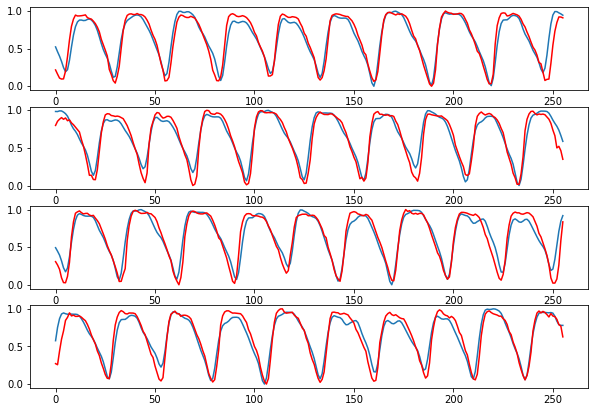

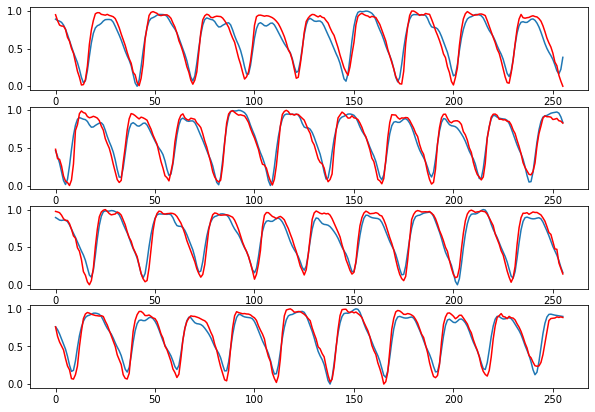

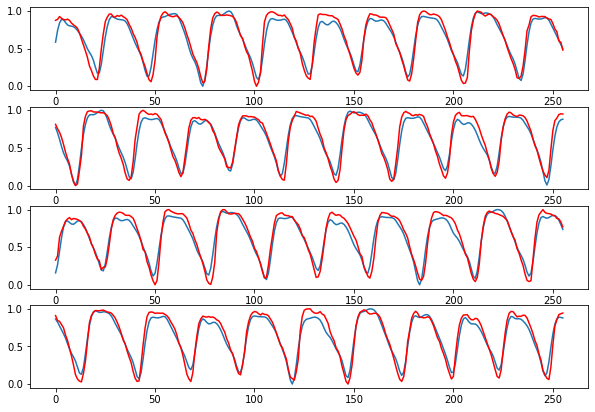

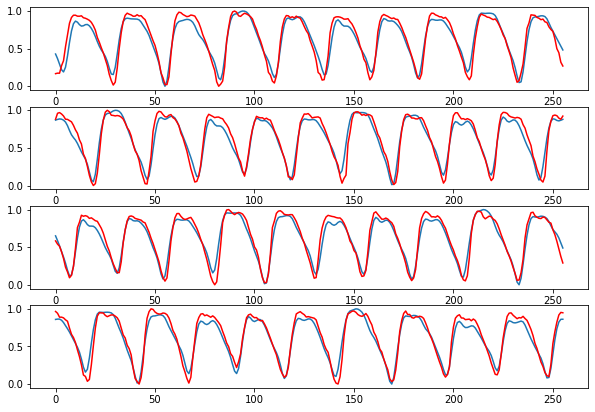

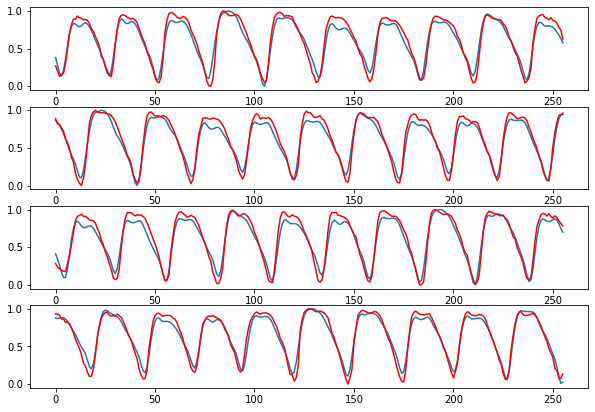

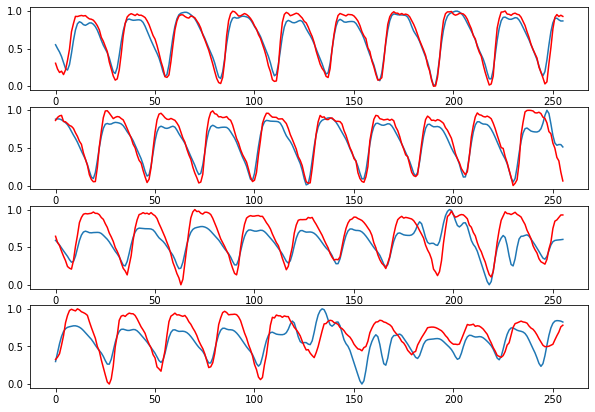

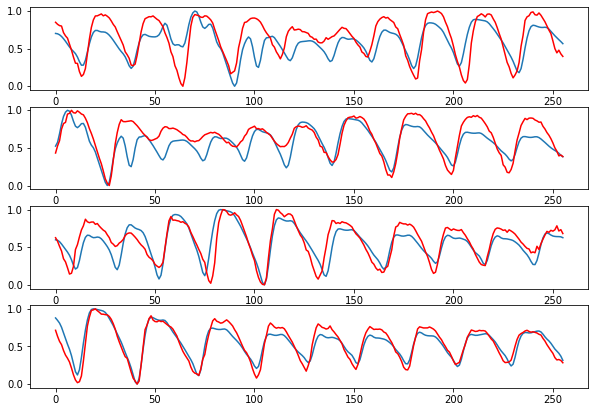

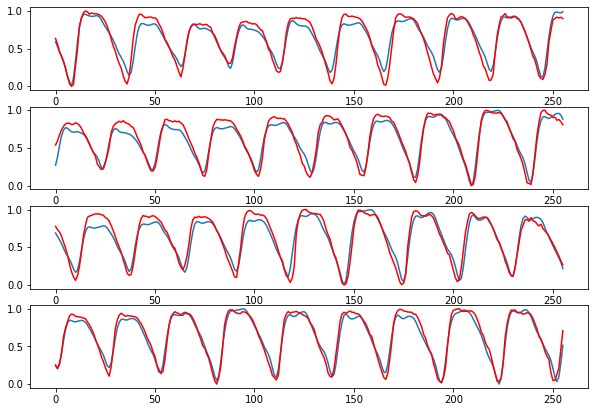

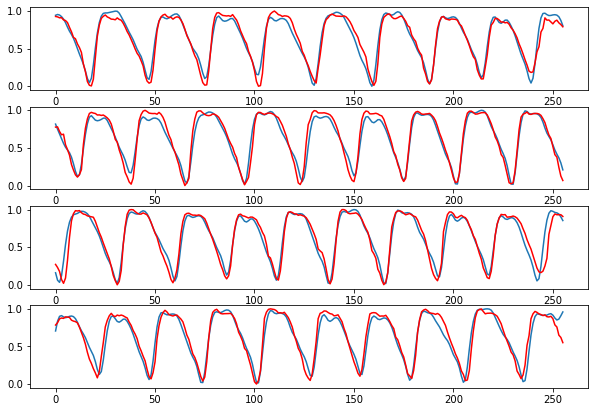

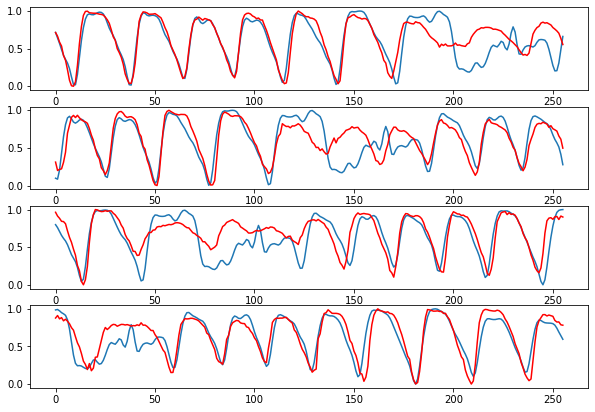

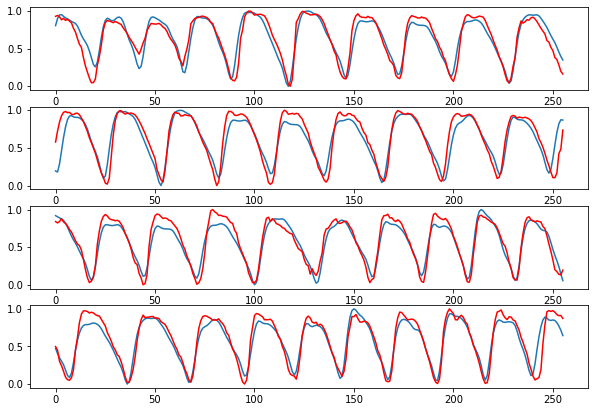

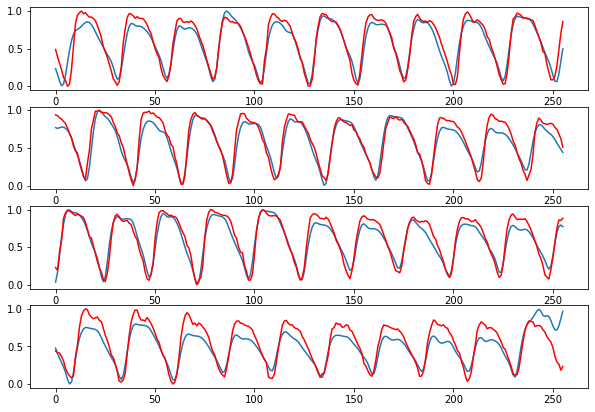

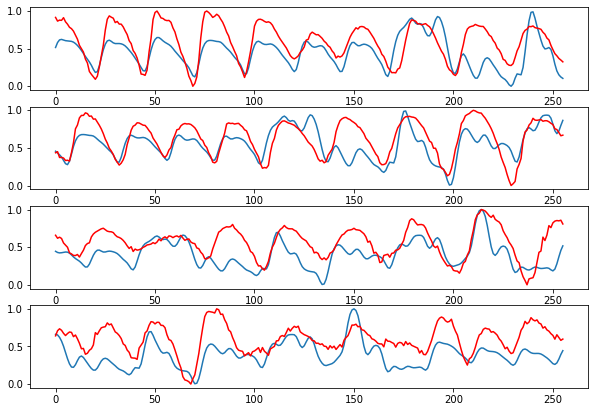

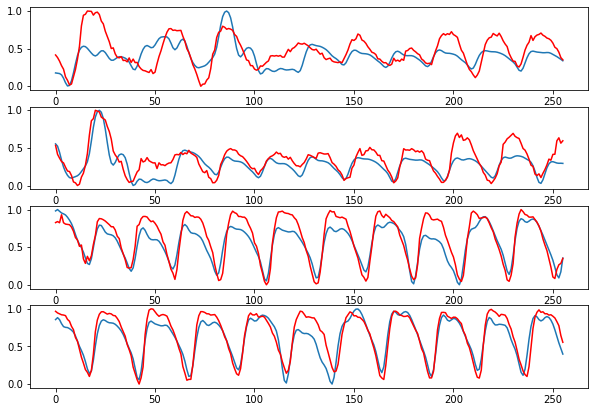

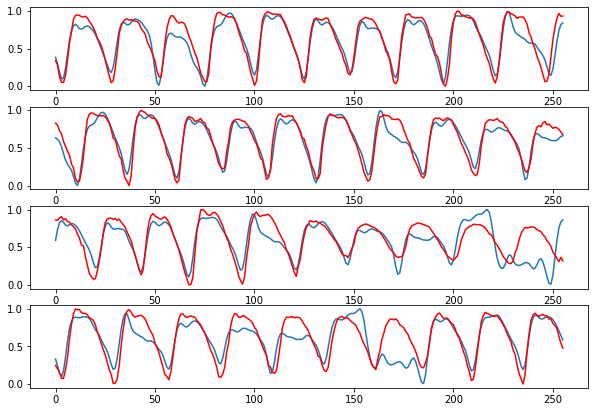

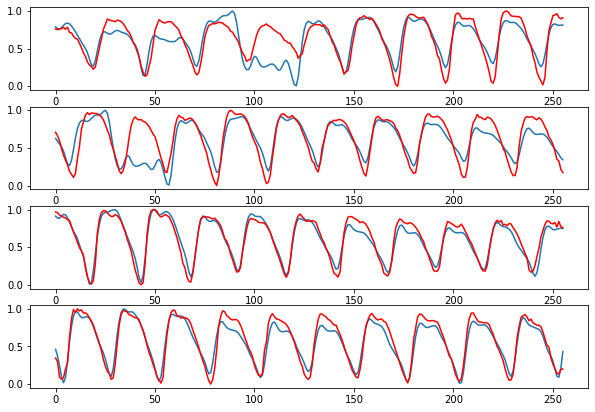

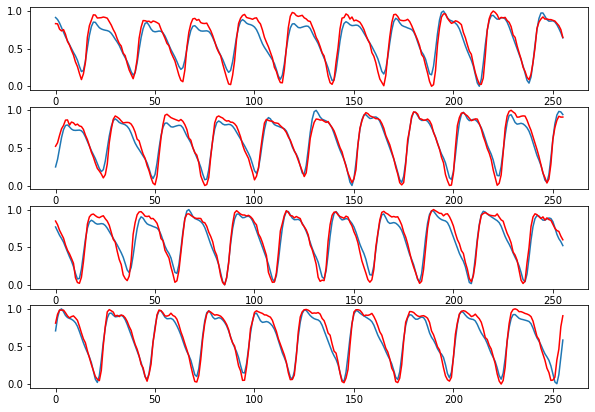

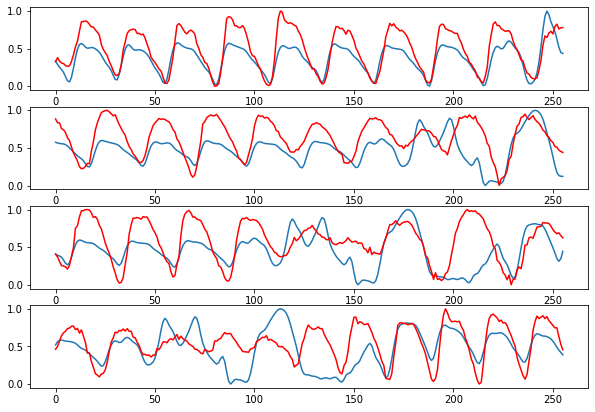

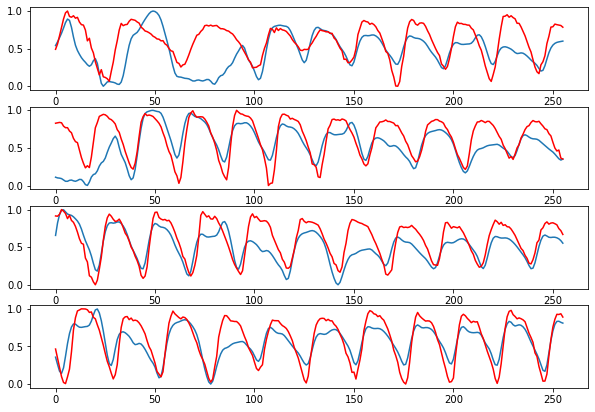

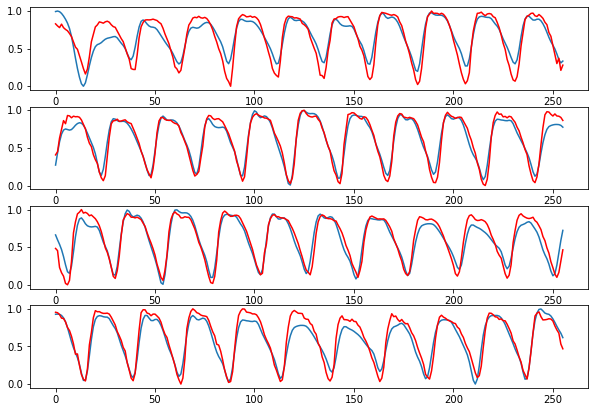

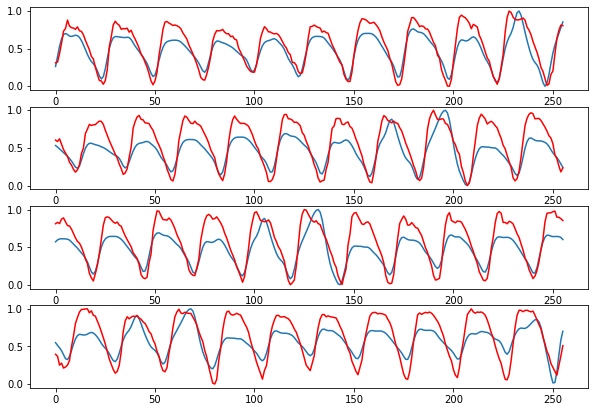

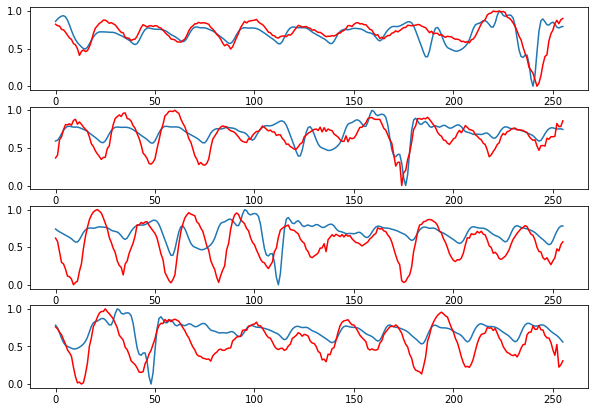

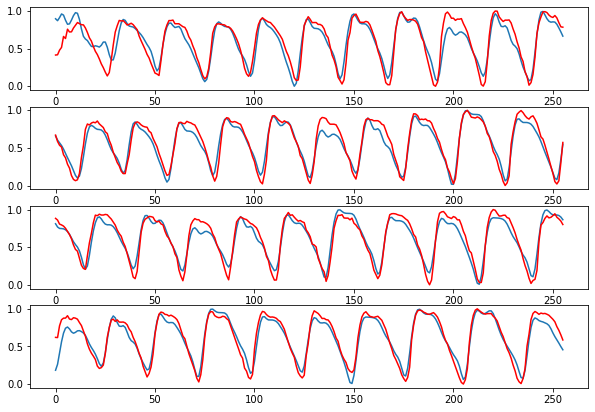

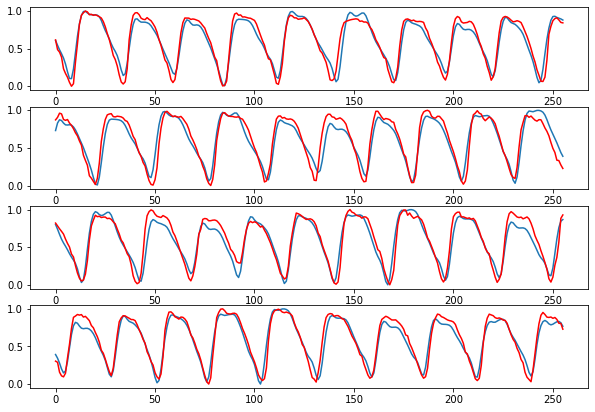

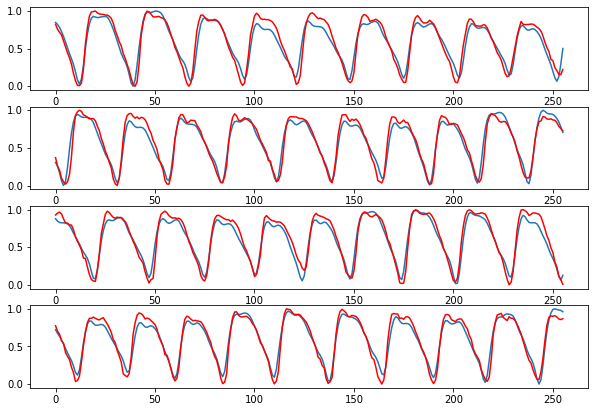

In [95]:
def custom_loss(y_true,y_pred):
    y_pred_attention = 1+y_pred[:,:,1]
    y_pred = y_pred[:,:,0]
    y_true = y_true[:,:,0]
    loss = K.mean(K.square(y_true-y_pred)*y_pred_attention)
    return loss

import keras.losses
keras.losses.custom_loss = custom_loss
# from keras.models import load_model
# model = load_model(filepath)
model = get_model()
model.load_weights(filepath)

test_y_pred = model.predict(test_x)[:,:,0].reshape(-1,256,1)

for k in range(test_y_pred.shape[0]):
    test_y_pred[k]  = MinMaxScaler().fit_transform(test_y_pred[k])

%matplotlib inline
for i in range(100,200,4):
    
    fig,ax = plt.subplots(4,1,figsize=(10,7))
    ax[0].plot(test_y[i])
    ax[0].plot(test_y_pred[i],'r')
    ax[1].plot(test_y[i+1])
    ax[1].plot(test_y_pred[i+1],'r')
    ax[2].plot(test_y[i+2])
    ax[2].plot(test_y_pred[i+2],'r')
    ax[3].plot(test_y[i+3])
    ax[3].plot(test_y_pred[i+3],'r')
    
    plt.show()



In [ ]:
y_pred_attention = 1+y_pred[:,:,1]
    y_pred = y_pred[:,:,0]
    y_true = y_true[:,:,0]
    loss = K.sum(K.square(y_true-y_pred)*y_pred_attention)

In [ ]:
y_pred = K.variable(np.random.uniform(0,2,(500,256,2)))

In [ ]:
y_pred_attention = 1+y_pred[:,:,1]
y_pred = y_pred[:,:,0]

In [ ]:
y_true = K.variable(np.random.uniform(0,2,(500,256,1)))

In [ ]:
y_true = y_true[:,:,0]

In [ ]:
K.mean(K.sqrt(K.square(y_true-y_pred)*y_pred_attention))